In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
excel_file = 'current_no_fault_time_series.xlsx'
df = pd.read_excel(excel_file)
current_data = df['Current(A)'].values
# Normalize the data to the range [0, 1] since LSTM is sensitive to scale
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(current_data.reshape(-1, 1))

In [4]:
# Split the data into training and test sets
#train_size = int(len(normalized_data) * 0.8)
train_size = 500
train_data, test_data = normalized_data[:train_size], normalized_data[train_size:]
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)
sequence_length = 10  #sequence length (number of data points to consider for prediction)

In [5]:
# Creating the training sequences
X_train, y_train = create_sequences(train_data, sequence_length)
# Creating the test sequences
X_test, y_test = create_sequences(test_data, sequence_length)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  #samples, time steps, features
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Build the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    keras.layers.LSTM(units=50),
    keras.layers.Dense(units=1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)
y_test = scaler.inverse_transform(y_test)

Epoch 1/50
8/8 [==============================] - 6s 16ms/step - loss: 0.2392
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0278
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0176
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0117
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0047
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0034
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 8/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0011
Epoch 9/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0010
Epoch 10/50
8/8 [==============================] - 0s 16ms/step - loss: 8.9666e-04
Epoch 11/50
8/8 [==============================] - 0s 16ms/step - loss: 8.8280e-04
Epoch 12/50
8/8 [==============================] - 0s 16ms/step - loss: 8.7492e-04
Epoch 13/50
8/8 [==============================] 

Root Mean Squared Error (RMSE): 0.27769707021379314


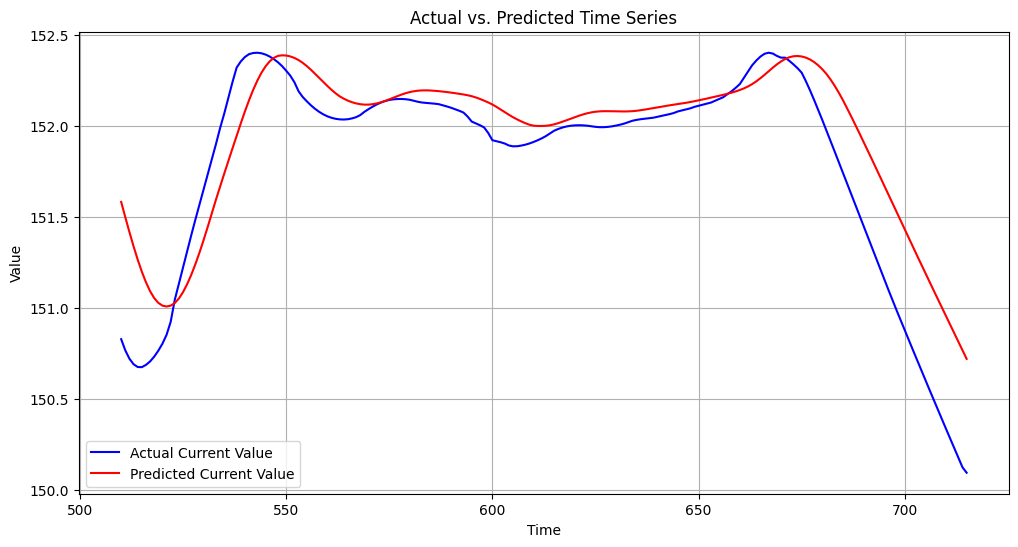

In [6]:
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)
plt.figure(figsize=(12, 6))
time_steps = range(len(current_data))
plt.plot(time_steps[train_size + sequence_length:], y_test, label='Actual Current Value', color='blue')
plt.plot(time_steps[train_size + sequence_length:], predicted_values, label='Predicted Current Value', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
df = pd.DataFrame(predicted_values)
excel_file_path = 'predicted_values_nofault.xlsx'  
df.to_excel(excel_file_path, index=False)
print(f"Data exported to {excel_file_path} successfully.")

Data exported to predicted_values_nofault.xlsx successfully.
